In [5]:
%matplotlib inline

# Analysis of COVID-19 case data using WHO and ECDC reported dataset
# Chad R. Frost
# chad@chadfrost.com
# (c) 2020

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates
import pandas as pd

# Exponential growth model
#def func(x, a, b, c):
#    return a * np.exp(b * x) + c

# Sigmoid (logistic) model
def func(x, a,b,c):
    return a / (c + np.exp(x*b*(-1)))

# R2 assessment of fit to data
def r2(x, y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)

    return r2

# Utililty conversion from datetime to numeric list (used to plot) and array referenced to a common date (used to fit)
def dates2fit(dates, refdate): # where dates = list of desired dates, as datetime; refdate = starting date
    refdate = mdates.date2num(refdate)
    numdates = mdates.date2num(dates)
    fitdates = np.array(numdates, dtype=float)
    fitdates = fitdates - refdate
    return(numdates, fitdates)

# MAIN ==========

# Get the data
## Data from https://ourworldindata.org/coronavirus-source-data
## (and see also the excellent work of https://twitter.com/_HannahRitchie)
## Create dataframe from csv file at URL
db = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv', parse_dates=True)
#db = pd.read_csv('full_data.csv', parse_dates=True)

print(db.head()) # Just to confirm that we've loaded a real data set


         date     location  new_cases  new_deaths  total_cases  total_deaths
0  2019-12-31  Afghanistan        0.0           0          0.0             0
1  2020-01-01  Afghanistan        0.0           0          0.0             0
2  2020-01-02  Afghanistan        0.0           0          0.0             0
3  2020-01-03  Afghanistan        0.0           0          0.0             0
4  2020-01-04  Afghanistan        0.0           0          0.0             0


In [6]:
## Create subset dataframe just for US
db_us = db[db['location']=='United States'].copy() # Make a copy, as we'll add columns later relevant only to this slice
total = db_us['total_cases'].tolist()
print(db_us.tail())


             date       location  new_cases  new_deaths  total_cases  \
12991  2020-04-23  United States    17588.0        1721     842629.0   
12992  2020-04-24  United States    26543.0        3179     869172.0   
12993  2020-04-25  United States    21352.0        1054     890524.0   
12994  2020-04-26  United States    48529.0        2172     939053.0   
12995  2020-04-27  United States    26857.0        1687     965910.0   

       total_deaths  
12991         46784  
12992         49963  
12993         51017  
12994         53189  
12995         54876  


In [7]:
# Fit the data
## make a monotonically increasing list representing time (days), for use in curve-fitting
x = range(len(total))

## put the running total into array of floats for curve fitting
y = np.array(total, dtype=float)

## Perform a least-squares fit to the model
popt, pcov = curve_fit(func, x, y, p0=(.01,.2,1))  # , p0=(0.1,0.2,.2)
print(f'Fit to recent data: a = {popt[0]} , b = {popt[1]}, c = {popt[2]}')

# Output: Plot the data & fits
## Create data to plot the fitted function 
y_fit = func(x, *popt)
db_us['y_fit']=y_fit # Add column to dataframe

## Show the quality of the fit
print(f'R2: {r2(x,y,y_fit)}')


Fit to recent data: a = 0.4608970294460154 , b = 0.1423095142593439, c = 4.5138530720780174e-07
R2: 0.9978385752223166


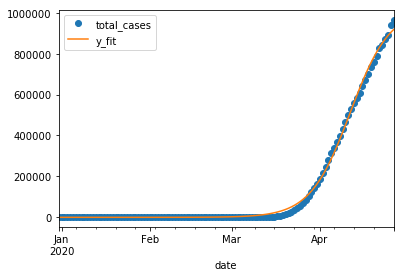

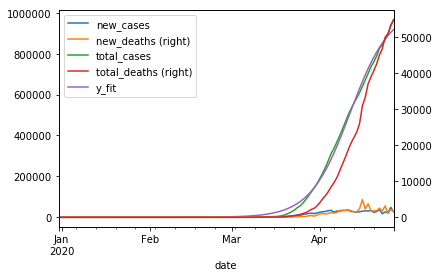

In [8]:
# Do some plots!
## See https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.htm

## convert date col to datetime format
db_us['date'] = pd.to_datetime(db_us['date'])

## total cases and curve fit to data
ax1 = db_us.plot(x='date', y=['total_cases', 'y_fit'], style=['o','-'])
plt.legend()

## all data  in the dataframe (e.g. including fit)
#db_us.plot(secondary_y=('total_deaths','new_deaths'),logy=True)
ax2 = db_us.plot(x='date', secondary_y=('total_deaths','new_deaths'))
           

Today: 923,241
+One week: 982,620
+Two weeks: 1,006,527


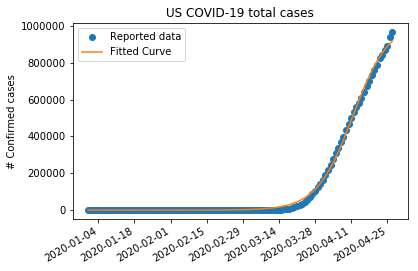

In [9]:
# Create var for projections
refdate = db_us.get_value(0,0, takeable=True) # Pull first element, = starting date

(today, today_fit) = dates2fit(datetime.today(), refdate)
(nextweek, nextweek_fit) = dates2fit(datetime.today()+timedelta(days=7), refdate)
(next2week, next2week_fit) = dates2fit(datetime.today()+timedelta(days=14), refdate)

# Compute discrete date projections
est_today = func(today_fit, *popt)
est_1wk = func(nextweek_fit, *popt)
est_2wk = func(next2week_fit, *popt)
print(f'Today: {est_today:,.0f}')
print(f'+One week: {est_1wk:,.0f}')
print(f'+Two weeks: {est_2wk:,.0f}')

# Plot stuff
## Zoomed in
fig3 = plt.figure()
plt.plot_date(x=db_us['date'],y=total, label="Reported data")
plt.plot_date(x=db_us['date'], y=y_fit, linestyle='-', marker="None", label="Fitted Curve")
#plt.plot_date(x=datenum_fit_all, y=y_fit_all, linestyle='--', marker="None", label="Fitted Curve (all data)")
fig3.autofmt_xdate()
plt.ylabel('# Confirmed cases')
plt.title('US COVID-19 total cases')
l = plt.legend()

Fit to fatality data: a = 0.0008629290483347212 , b = 0.16851087798453082, c = 1.358426417288289e-08
R2: 0.9992250680634814
Today: 54,853
+One week: 60,580
+Two weeks: 62,589


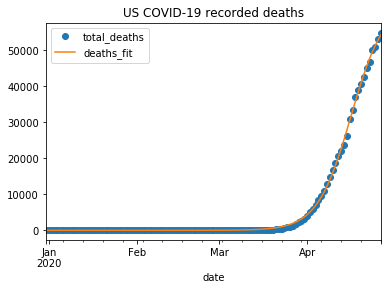

In [10]:
# Fit to fatalities
deaths = db_us['total_deaths'].tolist()

## Perform a least-squares fit to the model
popt, pcov = curve_fit(func, x, deaths, p0=(.01,.2,1))  # , p0=(0.1,0.2,.2)
print(f'Fit to fatality data: a = {popt[0]} , b = {popt[1]}, c = {popt[2]}')

deaths_fit = func(x, *popt)
db_us['deaths_fit']=deaths_fit # Add column to dataframe

## Show the quality of the fit
print(f'R2: {r2(x,deaths,deaths_fit)}')

# Compute discrete date projections
est_today = func(today_fit, *popt)
est_1wk = func(nextweek_fit, *popt)
est_2wk = func(next2week_fit, *popt)
print(f'Today: {est_today:,.0f}')
print(f'+One week: {est_1wk:,.0f}')
print(f'+Two weeks: {est_2wk:,.0f}')

## total deaths and curve fit to data
ax3 = db_us.plot(x='date', y=['total_deaths', 'deaths_fit'], style=['o','-'],title="US COVID-19 recorded deaths")
l = plt.legend()


In [13]:
# How long until (n) deaths?
# First, we need the inverse of the exponential
# function we fitted to the data, then we
# can use the fit parameters we obtained (in popt)
# to compute the time (y) for any given # of fatalities, (x).
#def inv_func(y, a, b, c):
    # if y = f(x) = a * e^(bx) + c, then:
    # (y - c)/a = e^(bx)
    # ln((y-c)/a) = bx
    # x = ln((y-c)/a)/b
#    return np.log((y-c)/a)/b # log is natural log in NumPy (vs log10)

# Inverse of sigmoid function
def inv_func(y, a, b, c):
    # y = f(x) = a / (c + np.exp(x*b*(-1)))
    # a/y = c + e^(-bx)
    # a/y - c = e^(-bx)
    # ln(a/y - c) = -bx
    # x = -ln(a/y - c)/b
    return np.log(a/y - c)/b*(-1)

current_deaths = db_us['total_deaths'].iloc[-1]
current_days = db_us['total_deaths'].count()
print(f'We are {current_days} days in...')
print(f'Days to 60K deaths: {inv_func(6e4, *popt)-current_days:,.1f}')
print(f'Days to 61K deaths: {inv_func(61e3, *popt)-current_days:,.1f}')
print(f'Days to 63K deaths: {inv_func(63e3, *popt)-current_days:,.1f}')
#print(f'Days to 100K deaths: {inv_func(1e5, *popt)-current_days:,.1f}')
#print(f'Days to 1M deaths: {inv_func(1e6, *popt)-current_days:,.1f}')
#print(f'Days to 10M deaths: {inv_func(1e7, *popt)-current_days:,.1f}')
#print(f'Days to 100M deaths: {inv_func(1e8, *popt)-current_days:,.1f}')

We are 119 days in...
Days to 60K deaths: 5.3
Days to 61K deaths: 7.4
Days to 63K deaths: 16.9


55.5321014819


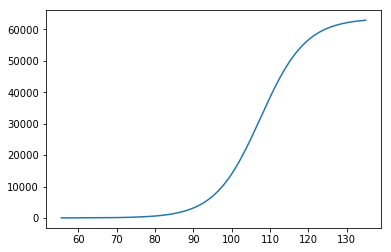

In [18]:
# Hm, something's not quite right there... 
# Let's plot the function
d = range(10,63000,100)
t = inv_func(d, *popt)
plt.plot(t,d)

(a,b,c)=popt
print(np.log((10-c)/a)/b)

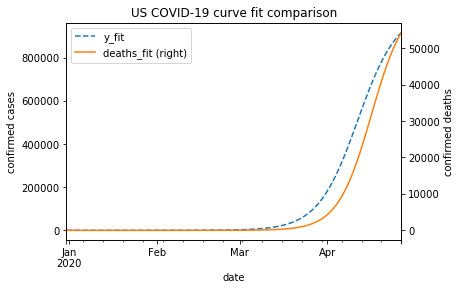

In [15]:
# What do the cases vs deaths curves look like?
#ax4 = db_us.loc[:,['y_fit','deaths_fit']].plot(secondary_y=['deaths_fit'],style=['--','-'])
# Plotting it as per above, doesn't allow setting of labels
ax4 = db_us.loc[:,['y_fit']].plot(x=db_us['date'],style='--')
ax4.set_ylabel('confirmed cases')
ax5 = db_us.loc[:,['deaths_fit']].plot(x=db_us['date'], secondary_y=True, ax=ax4)
ax5.set_ylabel('confirmed deaths')
ax5.set_title('US COVID-19 curve fit comparison')

# Looks like above pattern figures out the legend. It wasn't, originally,
# in which case the lines below do the trick.
# ask matplotlib for the plotted objects and their labels
#lines, labels = ax4.get_legend_handles_labels()
#lines2, labels2 = ax5.get_legend_handles_labels()
#ax5.legend(lines + lines2, labels + labels2, loc=0)

